Given a graph and k colors, find the most optimal arangement for not having same colors along the edge.  

In [112]:
from qiskit_optimization import QuadraticProgram
from qiskit import BasicAer
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.utils import QuantumInstance
from qiskit.primitives import Sampler
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA
import networkx as nx 
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(2, 2))

<Figure size 200x200 with 0 Axes>

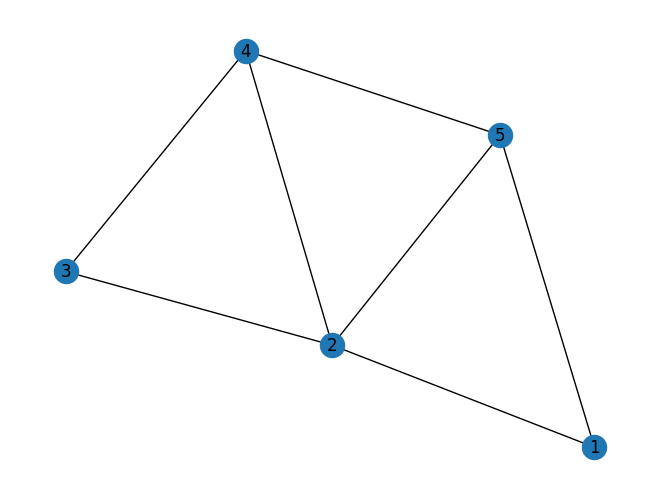

In [113]:
nodes = [1,2,3,4,5]
colors = [1,2,3]
edges = [[1,5],[1,2],[2,3],[2,4],[2,5],[4,5],[3,4]]

G = nx.Graph()

G.add_nodes_from(nodes)
for s,e in edges:
    G.add_edge(s,e)

nx.draw(G, with_labels=True)


### Theory
Lets say nodes in the graph are n and number of colors is k. Total number of binary choices is n*k. 

if nodes are 1,2,3,4,5 and colors are 1,2,3, then the binary choices emerge from the logic below. 

$ x_{11}, x_{12}, x_{13},x_{21}, x_{22}, x_{23},x_{31}, x_{32}, x_{33}, x_{41}, x_{42}, x_{43},x_{51}, x_{52}, x_{53} $

The above choices can be mapped to binary choices as below. 

$ x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_{10}, x_{11}, x_{12}, x_{13}, x_{14}, x_{15}$

#### Constraints and penalties

- Linear constraints (same group above cannot be assigned the same color. )

$\quad \quad  x_1 + x_2 + x_3 == 1 $

- Adjacent edges are preferred not to be assigned the same color. (x_1 and x_4 are same color binary choice between nodes 1,2)

$ \quad \quad x_1 + x_4 <= 1 $ 

- Penalties 

    If we convert the linear constaint into penalties, it will take the form below for one constraint, 

    $ \quad P(x_1 + x_2 + x_3 - 1)^2 = P(x1^2 + x2^2 + x3^2 -2.x_1- 2.x_2- 2.x_3- 2.x_1.x_2- 2.x_2.x_3- 2.x_1.x_3 + 1) $

    Convert $ x_i^2 = x_i $ because the variables are binary.
     
    $ \quad  P(x_1 + x_2 + x_3 - 1)^2 = P( -x_1- x_2- x_3- 2.x_1.x_2- 2.x_2.x_3- 2.x_1.x_3 + 1)$


In [114]:
total = len(nodes)*len(colors)

mod = QuadraticProgram("k coloring problem")

for i in range(1,total+1):
    mod.binary_var("x"+str(i)) 

cons = 1

for s,e in edges:
    for color in colors:
        c1 = (s*len(colors) - len(colors))+color
        c2 = (e*len(colors) - len(colors))+color
        linear_cons = {}
        linear_cons["x"+str(c1)] = 1
        linear_cons["x"+str(c2)] = 1
        mod.linear_constraint(linear=linear_cons, sense="<=", rhs=1, name="lin_eq" + str(cons))
        cons += 1

for color in range(1,total+1,len(colors)):
    linear_cons = {}
    for c in colors:
        linear_cons["x"+str(color+c-1)] = 1

    mod.linear_constraint(linear=linear_cons, sense="=", rhs=1, name="lin_eq" + str(cons))
    cons += 1

Q = {}
P = 50
linear_cons = {}

for i in range(1,total+1):
    linear_cons["x"+str(i)] = -1*P + 1

for i in range(1,total+1,len(colors)):
    Q[("x"+str(i),"x"+str(i+1))] = 2*P
    Q[("x"+str(i),"x"+str(i+2))] = 2*P
    Q[("x"+str(i+1),"x"+str(i+2))] = 2*P

mod.minimize(linear=linear_cons, quadratic=Q)
print(mod.prettyprint())

Problem name: k coloring problem

Minimize
  100*x1*x2 + 100*x1*x3 + 100*x10*x11 + 100*x10*x12 + 100*x11*x12 + 100*x13*x14
  + 100*x13*x15 + 100*x14*x15 + 100*x2*x3 + 100*x4*x5 + 100*x4*x6 + 100*x5*x6
  + 100*x7*x8 + 100*x7*x9 + 100*x8*x9 - 49*x1 - 49*x10 - 49*x11 - 49*x12
  - 49*x13 - 49*x14 - 49*x15 - 49*x2 - 49*x3 - 49*x4 - 49*x5 - 49*x6 - 49*x7
  - 49*x8 - 49*x9

Subject to
  Linear constraints (26)
    x1 + x13 <= 1  'lin_eq1'
    x14 + x2 <= 1  'lin_eq2'
    x15 + x3 <= 1  'lin_eq3'
    x1 + x4 <= 1  'lin_eq4'
    x2 + x5 <= 1  'lin_eq5'
    x3 + x6 <= 1  'lin_eq6'
    x4 + x7 <= 1  'lin_eq7'
    x5 + x8 <= 1  'lin_eq8'
    x6 + x9 <= 1  'lin_eq9'
    x10 + x4 <= 1  'lin_eq10'
    x11 + x5 <= 1  'lin_eq11'
    x12 + x6 <= 1  'lin_eq12'
    x13 + x4 <= 1  'lin_eq13'
    x14 + x5 <= 1  'lin_eq14'
    x15 + x6 <= 1  'lin_eq15'
    x10 + x13 <= 1  'lin_eq16'
    x11 + x14 <= 1  'lin_eq17'
    x12 + x15 <= 1  'lin_eq18'
    x10 + x7 <= 1  'lin_eq19'
    x11 + x8 <= 1  'lin_eq20'
    x

In [115]:
quantum_instance = Sampler()
qaoa_mes = QAOA(quantum_instance, COBYLA(), reps=2)
qaoa = MinimumEigenOptimizer(qaoa_mes)

qaoa_result = qaoa.solve(mod)
[qaoa_result.x], [qaoa_result.fval]


([array([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.])],
 [-245.0])

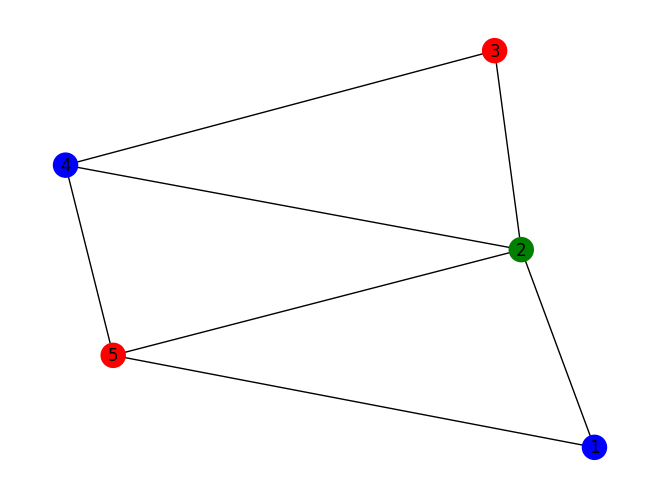

In [116]:
node_colors = ["red", "blue", "green"]
color_map = ([node_colors[list(qaoa_result.x[i:i + len(colors)]).index(1)] for i in range(0, len(qaoa_result.x), len(colors))])
nx.draw(G, node_color=color_map, with_labels=True)
